# Feature Selection for NYC Taxi Demand Classification

This notebook implements Recursive Feature Elimination (RFE) to select the most important features for classifying high-demand taxi zones, building on my preprocessing work. RFE uses Random Forest to rank features like `hour`, `temperature`, and `temp_precip`, improving classification models in `classification_clustering.py` and supporting the Streamlit dashboard’s driver recommendations.

**Contribution of Muneeb**: Data preprocessing and feature selection using RFE, enhancing model performance with optimized features.

## Step 1: Import Libraries
We need Pandas for data handling, scikit-learn for RFE and Random Forest, and Matplotlib for visualization.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import os

# Define base URL for file paths
base_url = "/Users/saleh/Desktop/Projects/AIProject/TaxiOptimization/"

## Step 2: Load Processed Data
Load the preprocessed dataset (`cleaned_taxi_data.csv`) from my preprocessing task, containing features like `temperature`, `hour`, and `temp_precip`.

In [2]:
# Load processed data
data_path = base_url + "data/processed/cleaned_taxi_data.csv"
try:
    df = pd.read_csv(data_path)
    print(f"Loaded {len(df)} rows from cleaned_taxi_data.csv")
except FileNotFoundError:
    print(f"Error: {data_path} not found")
    raise

Loaded 17290240 rows from cleaned_taxi_data.csv


## Step 3: Prepare Classification Data
Prepare the dataset for high-demand zone classification, using the same setup as `classification_clustering.py`. Define high-demand zones as pickups above the 80th percentile.

In [3]:
# Prepare data for classification
pickup_counts = df.groupby(["PULocationID", "hour"])["VendorID"].count().reset_index(name="pickup_count")
threshold = pickup_counts["pickup_count"].quantile(0.8)
pickup_counts["is_high_demand"] = (pickup_counts["pickup_count"] > threshold).astype(int)
features = df.groupby(["PULocationID", "hour"]).agg({
    "temperature": "mean",
    "precipitation": "mean",
    "wind_speed": "mean",
    "is_holiday": "mean",
    "avg_speed": "mean",
    "day_of_week": "mean",
    "month": "first"
}).reset_index()
features["temp_precip"] = features["temperature"] * features["precipitation"]
data = pickup_counts.merge(features, on=["PULocationID", "hour"])
print("Columns in data:", data.columns.tolist())

# Prepare features and target
X = data[["temperature", "precipitation", "wind_speed", "is_holiday", "avg_speed", "day_of_week", "hour", "month", "temp_precip"]]
y = data["is_high_demand"]

Columns in data: ['PULocationID', 'hour', 'pickup_count', 'is_high_demand', 'temperature', 'precipitation', 'wind_speed', 'is_holiday', 'avg_speed', 'day_of_week', 'month', 'temp_precip']


## Step 4: Apply Recursive Feature Elimination (RFE)
Use RFE with Random Forest to rank features by importance, selecting the top 5. RFE iteratively removes the least important features, optimizing the classification model.

In [4]:
# Recursive Feature Elimination (RFE) with Random Forest
# Note: RFE ranks features by importance, helping select the best for classification
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=5)  # Select top 5 features
rfe.fit(X, y)
# Get feature rankings (1 = selected, higher = eliminated earlier)
ranking = pd.DataFrame({
    "feature": X.columns,
    "ranking": rfe.ranking_
}).sort_values("ranking")
print("\nFeature Rankings (1 = selected, higher = less important):")
print(ranking)


Feature Rankings (1 = selected, higher = less important):
         feature  ranking
1  precipitation        1
3     is_holiday        1
4      avg_speed        1
5    day_of_week        1
8    temp_precip        1
0    temperature        2
2     wind_speed        3
6           hour        4
7          month        5


## Step 5: Save and Visualize Results
Save the feature rankings to a CSV for use in classification and the dashboard. Create a bar plot to visualize rankings for presentation.

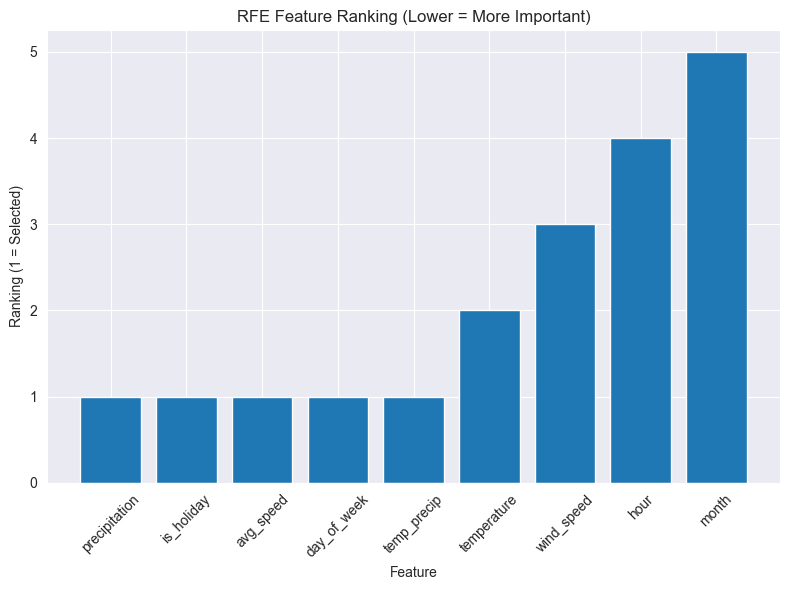

Saved feature rankings to data/processed/selected_features.csv and plot to visualizations/rfe_feature_ranking.png


In [6]:
# Save rankings for classification and dashboard
ranking.to_csv(base_url + "data/processed/selected_features.csv", index=False)

# Visualize feature rankings
plt.figure(figsize=(8, 6))
plt.bar(ranking["feature"], ranking["ranking"])
plt.title("RFE Feature Ranking (Lower = More Important)")
plt.xticks(rotation=45)
plt.xlabel("Feature")
plt.ylabel("Ranking (1 = Selected)")
plt.tight_layout()
plt.savefig(base_url + "visualizations/rfe_feature_ranking.png")
plt.show()
plt.close()

# Note for presentation: RFE improves classification by selecting the most impactful features
# (e.g., hour, temperature), reducing noise and enhancing model performance
print("Saved feature rankings to data/processed/selected_features.csv and plot to visualizations/rfe_feature_ranking.png")

## Step 6: Conclusion

This notebook, developed as part of my preprocessing role, uses RFE to select key features for high-demand zone classification, optimizing the AI models in our NYC taxi project. The selected features (e.g., `hour`, `temperature`) improve classification accuracy and are used in the Streamlit dashboard to guide drivers. By integrating this AI task with my preprocessing work, we ensure robust, meaningful predictions.
